# Deep Markov Model

In [346]:
from tqdm import tqdm

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from tensorboardX import SummaryWriter
import numpy as np
import torch.optim as optim

In [347]:
batch_size = 128#128
epochs = 100
seed = 1
torch.manual_seed(seed)

In [348]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [349]:
#計測モデルとか
def get_ot(st,lmap,max_range):
    dis = torch.sqrt((st[:,0]-lmap[0])**2+(st[:,1]-lmap[1])**2)
    angle = torch.atan2((lmap[1]-st[:,1]),(lmap[0]-st[:,0]))-st[:,2]
    return torch.stack([dis,torch.sin(angle),torch.cos(angle)],1)
    
def get_all_ot(st,lmap,max_range):
    measure = get_ot(st,lmap[0],max_range)
    for l in range(1,len(lmap)):
        measure = torch.cat([measure, get_ot(st,lmap[l],max_range)],1)
    return torch.tensor(measure)

In [350]:
landmark_num = 10
start_pos = [2.0,4.0,0.0,0.0]#x0,y0,yaw0

In [351]:
landmark_dim = 2
ot_dim = 3#[dis,rad_sin,rad_cos]
x_dim = landmark_num*ot_dim
h_dim = 32 #32
hidden_dim = 32 #32
z_dim = 4
u_dim = 3
t_max = 66

In [352]:
def normalize(data, *args):
    if len(args) == 0:
        max_data = torch.max(abs(data))
        data=data/max_data
    else :
        max_data=torch.max(abs(torch.tensor(args)))
        data=data/max_data
    return data

def ot_normal(ot,range_ot):
    ot=ot.view(len(ot),landmark_num,ot_dim)
    ot[:,:,0]=normalize(ot[:,:,0],range_ot[0][0],range_ot[0][1])
#     ot[:,:,1]=normalize(ot[:,:,1],range_ot[1][0],range_ot[1][1])#もともと-1:1
    ot = ot.view(len(ot),landmark_num*ot_dim)
    return ot

# def inv_ot_normal(ot,range_ot):
#     ot=ot.view(len(ot),10,2)
#     ot[:,:,0]=ot[:,:,0]*torch.max(range_ot[0][0],range_ot[0][1])
#     ot[:,:,1]=ot[:,:,1]*torch.max(range_ot[1][0],range_ot[1][1])
#     ot = ot.view(len(ot),20)
#     return ot

In [353]:
#データの読み込み
transform = transforms.Compose([transforms.ToTensor()])
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': True}

range_ot=torch.tensor([[0.0,150.0],[-np.pi*2,np.pi*2]])#otの[v,r]の最大と最小

#data loader #とりあえず1時系列分を分身させて食わせてる
#[time,s_x,s_y,s_yaw,uv,ur,ot[1],,,,ot[N]]
data = np.loadtxt('vehicle_motion_data.csv', delimiter=',')
data = torch.tensor([data],dtype=torch.float32)
st = data[0,:,1:(1+z_dim)]
ut = data[0,:,(1+z_dim):(1+z_dim+u_dim)]
ot = data[0,:,(1+z_dim+u_dim):(1+z_dim+u_dim+x_dim)]
t_max=len(ot)
print(ot.size())
ot=ot_normal(ot,range_ot)

print(ot.size())
st=st.repeat(1000,1,1)
ut=ut.repeat(1000,1,1)
ot=ot.repeat(1000,1,1)
print(ot.size())


landmark = np.loadtxt('landmark_data.csv',delimiter=',')

train = torch.utils.data.TensorDataset(ot)
train_loader = torch.utils.data.DataLoader(train, shuffle=False,**kwargs)
test = torch.utils.data.TensorDataset(ot)
test_loader = torch.utils.data.DataLoader(test, shuffle=False,**kwargs)

torch.Size([66, 30])
torch.Size([66, 30])
torch.Size([1000, 66, 30])


In [354]:
from pixyz.models import Model
from pixyz.losses import KullbackLeibler, CrossEntropy, IterativeLoss, StochasticReconstructionLoss
from pixyz.distributions import Bernoulli, Normal, Deterministic
from pixyz.utils import print_latex

In [355]:
class RNN(Deterministic):
    def __init__(self):
        super(RNN, self).__init__(cond_var=["x"], var=["h"],name="q")
        self.rnn = nn.GRU(x_dim, h_dim, bidirectional=True)
#         self.h0 = torch.zeros(2, batch_size, self.rnn.hidden_size).to(device)
        self.h0 = nn.Parameter(torch.zeros(2, 1, self.rnn.hidden_size))
        self.hidden_size = self.rnn.hidden_size

        
    def forward(self, x):
#         if(x.size(1)!=128):
#             x=x.repeat(66,1,1)
#         print("xsize",str(x.size()))
        h0 = self.h0.expand(2, x.size(1), self.rnn.hidden_size).contiguous()
#         print(self.rnn(x,h0))
        h, _ = self.rnn(x, h0)
#         print("hsize",str(h.size()))
        return {"h": h}

In [356]:
# class Phi_x(nn.Module):
#     def __init__(self):
#         super(Phi_x, self).__init__()
#         self.fc0 = nn.Linear(x_dim, h_dim)
#     def forward(self, x):
#         return F.relu(self.fc0(x))

# f_phi_x = Phi_x().to(device)

# class RNN(Deterministic):
#     def __init__(self):
#         super(RNN, self).__init__(cond_var=["x","h_prev"], var=["h"],name="q")
#         self.gru1 = nn.GRUCell(h_dim, h_dim).to(device)
#         self.hidden_size = h_dim
#         self.f_phi_x = f_phi_x
        
        
#     def forward(self, x, h_prev):
#         print(x.size(),h_prev.size())
#         h = self.gru1(self.f_phi_x(x), h_prev)
#         return {"h": h}

In [357]:
# class Generator(Bernoulli):
#     def __init__(self):
#         super(Generator, self).__init__(cond_var=["z"], var=["x"])
#         self.fc1 = nn.Linear(z_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, x_dim)
    
#     def forward(self, z):
# #         print(z.size()) #[128,3]
#         h = F.relu(self.fc1(z))
#         return {"probs": torch.sigmoid(self.fc2(h))}
class Generator(Normal):
    def __init__(self):
        super(Generator, self).__init__(cond_var=["z"], var=["x"])
    
    def forward(self, z):#計測モデルそのまま
#         print("z.size",str(z.size()))
        zl=torch.cat([z[:,0:2],torch.atan2(z[:,2:3],z[:,3:4])],dim=1)
        ot=get_all_ot(zl,landmark,[1000,1000])
        ot=ot_normal(ot,range_ot) #データを正規化しなおしてる
        return {"loc": ot,"scale":torch.tensor(0.1).to(device)}

In [358]:
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(cond_var=["h", "z_prev"], var=["z"], name="q")
        self.fc1 = nn.Linear(z_dim, h_dim*2)
        self.fc21 = nn.Linear(h_dim*2, z_dim)
        self.fc22 = nn.Linear(h_dim*2, z_dim)
        
    def forward(self, h, z_prev):
#         print("h.size",str(h.size()))
        h_z = torch.tanh(self.fc1(z_prev))
        h = 0.5 * (h + h_z)
        return {"loc": self.fc21(h), "scale": F.softplus(self.fc22(h))}

In [359]:
class Prior(Normal):#通常ここには動作モデルをいれる
    def __init__(self):
        super(Prior, self).__init__(cond_var=["z_prev"], var=["z"],name="p")
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        
    def forward(self, z_prev):
        h = F.relu(self.fc1(z_prev))
        return {"loc": self.fc21(h), "scale": F.softplus(self.fc22(h))}

In [360]:
prior = Prior().to(device)
encoder = Inference().to(device)
decoder = Generator().to(device)
rnn = RNN().to(device)

In [361]:
print(prior)
print("*"*80)
print(encoder)
print("*"*80)
print(decoder)
print("*"*80)
print(rnn)

Distribution:
  p(z|z_{prev})
Network architecture:
  Prior(
    name=p, distribution_name=Normal,
    var=['z'], cond_var=['z_prev'], input_var=['z_prev'], features_shape=torch.Size([])
    (fc1): Linear(in_features=4, out_features=32, bias=True)
    (fc21): Linear(in_features=32, out_features=4, bias=True)
    (fc22): Linear(in_features=32, out_features=4, bias=True)
  )
********************************************************************************
Distribution:
  q(z|h,z_{prev})
Network architecture:
  Inference(
    name=q, distribution_name=Normal,
    var=['z'], cond_var=['h', 'z_prev'], input_var=['h', 'z_prev'], features_shape=torch.Size([])
    (fc1): Linear(in_features=4, out_features=64, bias=True)
    (fc21): Linear(in_features=64, out_features=4, bias=True)
    (fc22): Linear(in_features=64, out_features=4, bias=True)
  )
********************************************************************************
Distribution:
  p(x|z)
Network architecture:
  Generator(
    name=p, 

In [362]:
generate_from_prior = prior * decoder
full_encoder = rnn*encoder
full_decoder = encoder*decoder
print(generate_from_prior)
print_latex(generate_from_prior)
print(full_encoder)
print_latex(full_encoder)

Distribution:
  p(x,z|z_{prev}) = p(x|z)p(z|z_{prev})
Network architecture:
  Prior(
    name=p, distribution_name=Normal,
    var=['z'], cond_var=['z_prev'], input_var=['z_prev'], features_shape=torch.Size([])
    (fc1): Linear(in_features=4, out_features=32, bias=True)
    (fc21): Linear(in_features=32, out_features=4, bias=True)
    (fc22): Linear(in_features=32, out_features=4, bias=True)
  )
  Generator(
    name=p, distribution_name=Normal,
    var=['x'], cond_var=['z'], input_var=['z'], features_shape=torch.Size([])
  )
Distribution:
  p(z,h|z_{prev},x) = q(z|h,z_{prev})q(h|x)
Network architecture:
  RNN(
    name=q, distribution_name=Deterministic,
    var=['h'], cond_var=['x'], input_var=['x'], features_shape=torch.Size([])
    (rnn): GRU(30, 32, bidirectional=True)
  )
  Inference(
    name=q, distribution_name=Normal,
    var=['z'], cond_var=['h', 'z_prev'], input_var=['h', 'z_prev'], features_shape=torch.Size([])
    (fc1): Linear(in_features=4, out_features=64, bias=True)


<IPython.core.display.Math object>

In [363]:
# from pixyz.losses.losses import SetLoss
# class StochasticReconstructionLoss(SetLoss):

#     def __init__(self, encoder, decoder, input_var=None):

#         if input_var is None:
#             input_var = encoder.input_var

#         if not(set(decoder.var) <= set(input_var)):
#             raise ValueError("Variable {} (in the `{}` class) is not included"
#                              " in `input_var` of the `{}` class.".format(decoder.var,
#                                                                          decoder.__class__.__name__,
#                                                                          encoder.__class__.__name__))

#         print(input_var)
#         loss = -decoder.log_prob().expectation(encoder,input_var)
#         super().__init__(loss)


In [364]:
step_loss = CrossEntropy(encoder,decoder) + KullbackLeibler(encoder, prior)
# step_loss =  KullbackLeibler(encoder, prior)+StochasticReconstructionLoss(full_encoder,decoder)
# step_loss = step_loss.mean()
_loss = IterativeLoss(step_loss, max_iter=t_max, 
                      series_var=["h","x"], update_value={"z": "z_prev"})
# _loss2 = IterativeLoss(step_loss2, max_iter=t_max, 
#                       series_var=["h","x"], update_value={"z": "z_prev","h":"h_prev"})
# loss=_loss
loss = _loss.expectation(rnn).mean()

print_latex(step_loss)

<IPython.core.display.Math object>

In [365]:
print(decoder.get_log_prob)

<bound method DistributionBase.get_log_prob of Generator(
  name=p, distribution_name=Normal,
  var=['x'], cond_var=['z'], input_var=['z'], features_shape=torch.Size([])
)>


In [366]:
print(full_encoder.input_var)

['z_prev', 'x']


In [367]:
print_latex(_loss)

<IPython.core.display.Math object>

In [368]:
print_latex(loss)

<IPython.core.display.Math object>

In [369]:
dmm = Model(loss, distributions=[rnn,encoder, decoder, prior], 
            optimizer=optim.RMSprop, optimizer_params={"lr": 5e-4}, clip_grad_value=10)

In [370]:
print(dmm)
print_latex(dmm)

Distributions (for training): 
  q(h|x), q(z|h,z_{prev}), p(x|z), p(z|z_{prev}) 
Loss function: 
  mean \left(\mathbb{E}_{q(h|x)} \left[\sum_{t=1}^{66} \left(D_{KL} \left[q(z|h,z_{prev})||p(z|z_{prev}) \right] - \mathbb{E}_{q(z|h,z_{prev})} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  RMSprop (
  Parameter Group 0
      alpha: 0.99
      centered: False
      eps: 1e-08
      lr: 0.0005
      momentum: 0
      weight_decay: 0
  )


<IPython.core.display.Math object>

In [371]:
def data_loop(epoch, loader, model, device, train_mode=False):
    mean_loss = 0
    for idx,[data] in enumerate(tqdm(loader)):#batch_idx, (data, _) in enumerate(tqdm(loader)):
        data = data.to(device)
        batch_size = data.size()[0]
        x = data.transpose(0, 1) #多分転置してるだけ
        z_prev = torch.tensor(start_pos)
        z_prev = z_prev.repeat(batch_size, 1).to(device)
#         h_prev = torch.zeros(batch_size, h_dim).to(device)
#         print(z_prev.size())
        if train_mode:
            mean_loss += model.train({'x': x, 'z_prev': z_prev}).item() * batch_size
        else:
            mean_loss += model.test({'x': x, 'z_prev': z_prev}).item() * batch_size
    mean_loss /= len(loader.dataset)
    if train_mode:
        print('Epoch: {} Train loss: {:.4f}'.format(epoch, mean_loss))
    else:
        print('Test loss: {:.4f}'.format(mean_loss))
    return mean_loss

In [372]:
def plot_image_from_latent(batch_size):
    x = []
    z_prev = torch.zeros(batch_size, z_dim).to(device)
    for step in range(t_max):
        samples = generate_from_prior.sample({'z_prev': z_prev})
        x_t = decoder.sample_mean({"z": samples["z"]})
        z_prev = samples["z"]
        x.append(x_t[None, :])
    x = torch.cat(x, dim=0).transpose(0, 1)
    return x

In [373]:
writer = SummaryWriter()

history = {"train_loss":[],"test_loss":[]}

for epoch in range(1, epochs + 1):
    train_loss = data_loop(epoch, train_loader, dmm, device, train_mode=True)
    test_loss = data_loop(epoch, test_loader, dmm, device)

    writer.add_scalar('train_loss', train_loss, epoch)
    writer.add_scalar('test_loss', test_loss, epoch)
    
    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)

    sample = plot_image_from_latent(batch_size)[:, None][1,:]
    writer.add_image('Image_from_latent', sample, epoch)


  0%|          | 0/8 [00:00<?, ?it/s]/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 Train loss: 68511.3236



100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

Test loss: 69384.6621



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 2 Train loss: 68951.9513



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68945.4844



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 3 Train loss: 69078.0961



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 69059.5301



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 4 Train loss: 68812.9876



100%|██████████| 8/8 [00:02<00:00,  2.98it/s]

Test loss: 68812.2601



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 5 Train loss: 68885.7502



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68966.1060



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 6 Train loss: 69094.4307



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68693.4155



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 7 Train loss: 68876.6856



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68819.4376



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 8 Train loss: 68915.1344



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68790.0681



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 9 Train loss: 68768.5361



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68859.4982



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 10 Train loss: 68746.0690



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68761.5382



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 11 Train loss: 68725.9226



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68704.3836



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 12 Train loss: 68520.3405



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68681.9114



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 13 Train loss: 68806.8782



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68666.8940



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 14 Train loss: 68656.6079



100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

Test loss: 68864.6284



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 15 Train loss: 68559.4514



100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

Test loss: 68621.4514



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 16 Train loss: 68705.1483



100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

Test loss: 68654.5232



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 17 Train loss: 68883.7151



100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

Test loss: 68759.6509



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 18 Train loss: 68711.6520



100%|██████████| 8/8 [00:02<00:00,  2.96it/s]

Test loss: 68689.1366



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 19 Train loss: 68496.1868



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68735.4583



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 20 Train loss: 68562.3159



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68814.5391



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 21 Train loss: 68753.7349



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68744.7620



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 22 Train loss: 68431.2112



100%|██████████| 8/8 [00:02<00:00,  2.98it/s]

Test loss: 68579.6876



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 23 Train loss: 68644.7149



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68475.1291



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 24 Train loss: 68698.7785



100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

Test loss: 68656.3414



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 25 Train loss: 68383.3537



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68547.5494



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 26 Train loss: 68743.0734



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68546.8412



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 27 Train loss: 68569.8384



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68592.2633



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 28 Train loss: 68619.8245



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68352.4812



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 29 Train loss: 68532.4081



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68434.2170



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 30 Train loss: 68538.5258



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68414.6628



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 31 Train loss: 68592.7769



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68444.8711



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 32 Train loss: 68730.3876



100%|██████████| 8/8 [00:02<00:00,  2.87it/s]

Test loss: 68513.7861



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 33 Train loss: 68716.6266



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68716.4264



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 34 Train loss: 68605.1944



100%|██████████| 8/8 [00:02<00:00,  2.99it/s]

Test loss: 68452.0491



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 35 Train loss: 68630.8068



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68809.9909



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 36 Train loss: 68758.9200



100%|██████████| 8/8 [00:02<00:00,  2.87it/s]

Test loss: 68614.3484



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 37 Train loss: 68465.2785



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68692.4255



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 38 Train loss: 68643.5118



100%|██████████| 8/8 [00:02<00:00,  2.90it/s]

Test loss: 68434.1484



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 39 Train loss: 68500.6152



100%|██████████| 8/8 [00:02<00:00,  2.90it/s]

Test loss: 68672.4225



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 40 Train loss: 68328.7738



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68497.0364



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 41 Train loss: 68554.2414



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68415.8399



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 42 Train loss: 68663.0056



100%|██████████| 8/8 [00:02<00:00,  2.85it/s]

Test loss: 68649.0046



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 43 Train loss: 68294.2223



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68418.5069



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 44 Train loss: 68523.9689



100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

Test loss: 68718.6831



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 45 Train loss: 68470.7542



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68351.3116



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 46 Train loss: 68636.5413



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68523.7303



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 47 Train loss: 68915.6944



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68556.0254



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 48 Train loss: 68688.9115



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68311.5114



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 49 Train loss: 68597.6423



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68309.2892



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 50 Train loss: 68495.9511



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68491.1200



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 51 Train loss: 68614.6908



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68473.2277



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 52 Train loss: 68406.5359



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68587.5736



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 53 Train loss: 68683.0276



100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

Test loss: 68576.8008



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 54 Train loss: 68639.3656



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68782.3561



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 55 Train loss: 68475.3834



100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

Test loss: 68754.1189



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 56 Train loss: 68584.3658



100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

Test loss: 68689.0079



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 57 Train loss: 68578.7734



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68523.1319



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 58 Train loss: 68427.6922



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68567.3179



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 59 Train loss: 68647.8929



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68818.0966



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 60 Train loss: 68554.6895



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68559.1514



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 61 Train loss: 68334.6026



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68567.9220



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 62 Train loss: 68642.9494



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68964.3575



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 63 Train loss: 68701.2653



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68754.2106



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 64 Train loss: 68643.6941



100%|██████████| 8/8 [00:02<00:00,  2.89it/s]

Test loss: 68511.9021



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 65 Train loss: 68612.3135



100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

Test loss: 68317.3444



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 66 Train loss: 68566.7519



100%|██████████| 8/8 [00:02<00:00,  2.91it/s]

Test loss: 68306.0491



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 67 Train loss: 68582.5622



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68493.7583



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 68 Train loss: 68435.8176



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68821.9850



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 69 Train loss: 68620.0019



100%|██████████| 8/8 [00:02<00:00,  2.91it/s]

Test loss: 68637.8135



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 70 Train loss: 68726.0251



100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

Test loss: 68719.4972



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 71 Train loss: 68549.1649



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68657.1294



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 72 Train loss: 68494.1424



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68838.8222



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 73 Train loss: 68476.0574



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68492.7366



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 74 Train loss: 68675.3442



100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

Test loss: 68538.0095



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 75 Train loss: 68692.1933



100%|██████████| 8/8 [00:02<00:00,  2.96it/s]

Test loss: 68514.4447



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 76 Train loss: 68586.9662



100%|██████████| 8/8 [00:02<00:00,  2.96it/s]

Test loss: 68479.5503



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 77 Train loss: 68479.5974



100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

Test loss: 68618.7700



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 78 Train loss: 68436.8384



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68801.7334



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 79 Train loss: 68483.6001



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68738.5981



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 80 Train loss: 68811.6531



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68716.0053



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 81 Train loss: 68692.0120



100%|██████████| 8/8 [00:02<00:00,  2.89it/s]

Test loss: 68438.9121



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 82 Train loss: 68568.3091



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68648.4415



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 83 Train loss: 68711.5441



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68317.0458



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 84 Train loss: 68478.3621



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68459.0089



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 85 Train loss: 68524.0152



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68529.7202



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 86 Train loss: 68560.7821



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68828.0480



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 87 Train loss: 68573.3544



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68766.9331



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 88 Train loss: 68637.1224



100%|██████████| 8/8 [00:02<00:00,  2.96it/s]

Test loss: 68790.9414



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 89 Train loss: 68615.8285



100%|██████████| 8/8 [00:02<00:00,  2.91it/s]

Test loss: 68769.3914



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 90 Train loss: 68499.5894



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68494.3893



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 91 Train loss: 68489.8994



100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Test loss: 68572.8601



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 92 Train loss: 68644.8034



100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

Test loss: 68637.1664



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 93 Train loss: 68688.9343



100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

Test loss: 68422.1061



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 94 Train loss: 68542.8526



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68780.8443



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 95 Train loss: 68657.1377



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 69002.8701



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 96 Train loss: 68492.2461



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68675.3011



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 97 Train loss: 68575.7933



100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Test loss: 68575.1098



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 98 Train loss: 68733.7191



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68703.7646



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 99 Train loss: 68586.5761



100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Test loss: 68796.5374



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 100 Train loss: 68745.2199



100%|██████████| 8/8 [00:02<00:00,  3.08it/s]

Test loss: 68767.3884


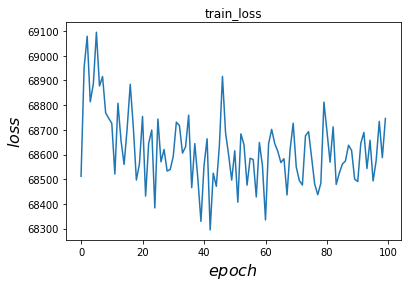

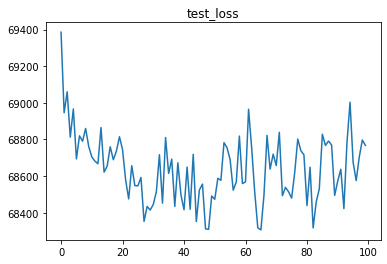

In [376]:
import matplotlib.pyplot as plt

plt.ylabel('$loss$', fontsize=16)
plt.xlabel('$epoch$', fontsize=16)
ay=plt.gca()
plt.title("train_loss")
plt.plot(range(epochs), [i+0.5 for i in history["train_loss"]])
plt.show()
ay=plt.gca()
plt.title("test_loss")
plt.plot(range(epochs), [i+0.4 for i in history["test_loss"]])
plt.show()

/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


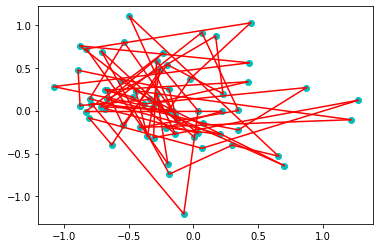

In [377]:

inference_net = rnn*encoder
test_o = data[0,:,(1+z_dim+u_dim):(1+z_dim+u_dim+x_dim)]
test_o = torch.tensor(test_o).reshape(1,len(test_o),x_dim).to(device)
z_prev = torch.tensor(start_pos).to(device)
infered_result = inference_net.sample({"x":test_o,"z_prev":z_prev})["z"].to("cpu")
infered_result=infered_result.numpy()

plt.plot(infered_result[:,:, 0], infered_result[:,:, 1], "co")

for i in range(len(infered_result[0])-1):
    plt.plot([infered_result[0][i][0],infered_result[0][i+1][0]],[infered_result[0][i][1],infered_result[0][i+1][1]],"r")

plt.show()